In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ns_f import ns_f
from optimal_traffic_scheduler import optimal_traffic_scheduler

First we initialize the data object, that stores information about all the packets that are and were transported in network. The index of this table is a unique identifier of the packet. The optional argument sets the inital size of that table.

In [2]:
dat = ns_f.data(1000)

In the next step we define the network by creating a number of nodes (servers and clients) with certain properties:

In [3]:
setup_dict_server = {}
setup_dict_server['v_max'] = 2000  # packets / s
setup_dict_server['s_max'] = 200  # packets
setup_dict_server['timeout'] = 1  # s

In [4]:
input_1 = ns_f.server(setup_dict_server, dat, name='input_1')
input_2 = ns_f.server(setup_dict_server, dat, name='input_2')
output_1 = ns_f.server(setup_dict_server, dat, name='output_1')
output_2 = ns_f.server(setup_dict_server, dat, name='output_2')
server_1 = ns_f.server(setup_dict_server, dat, name='server_1')
server_2 = ns_f.server(setup_dict_server, dat, name='server_2')

Furthermore we create connections between these nodes by defining a number of circuits. Each circuit has a start an end and an arbitrary number of stops in between. We create a very simple network with two circuits:

In [5]:
circuits = [
    {'route': [input_1, server_1, server_2, output_1]},
    {'route': [input_2, server_1, server_2, output_2]},
]

We can now call:

In [6]:
nw = ns_f.network(data=dat)
nw.from_circuits(circuits)

The network is defined now and can be simulated with TCP control, if desired. However, we want to use the OTS control algorithm. This distributed control algorithm runs independently at every server node and can be setup as follows:

In [7]:
dt_ots = 0.1
N_steps = 20
ots_weights = {'control_delta': 1, 'send': 1, 'store': 1, 'receive': 5}

In [8]:
# OTS clients
input_1.set_ots_client(dt_ots, N_steps)
input_2.set_ots_client(dt_ots, N_steps)
output_1.set_ots_client(dt_ots, N_steps)
output_2.set_ots_client(dt_ots, N_steps)

# OTS 
server_1.set_ots(dt_ots, N_steps, ots_weights)
server_2.set_ots(dt_ots, N_steps, ots_weights)

We differentiate between OTS nodes and ots clients. OTS nodes run an optimization problem to determine optimal sending rates and allotments for incoming packets, whereas clients will use simple operations to determine future sending rates and thresholds for incoming packet streams. 

The last step of the process involves calling:

In [9]:
nw.setup_ots(dt_ots, N_steps)

The optimizers are now ready to run.

We add some packets to the inputs, such that the network has something to do:

In [10]:
input_1.add_2_buffer(buffer_ind=0, circuit=0, n_packets=1000)
input_2.add_2_buffer(buffer_ind=0, circuit=1, n_packets=2000)

In [11]:
nw.run_ots()
#nw.control_mode = 'tcp'


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

  33 -9.1111111e+01 0.00e+00 1.17e-02  -8.6 6.34e-08    -  4.87e-01 4.87e-01s 22
  34 -9.1111111e+01 0.00e+00 1.15e-02  -8.6 3.34e-06    -  1.72e-02 1.72e-02s 22
  35 -9.1111111e+01 0.00e+00 1.00e-02  -8.6 6.66e-07    -  1.26e-01 1.26e-01s 22
  36 -9.1111111e+01 0.00e+00 6.63e-03  -8.6 2.47e-07    -  3.40e-01 3.40e-01s 22
  37 -9.1111111e+01 5.64e-09 3.24e-11  -8.6 9.64e-08    -  1.00e+00 1.00e+00s 22

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  -9.1111111061577844e+01   -9.1111111061577844e+01
Dual infeasibility......:   3.2418330173089593e-11    3.2418330173089593e-11
Constraint violation....:   5.6433457254948139e-09    5.6433457254948139e-09
Complementarity.........:   3.4846835877215600e-09    3.4846835877215600e-09
Overall NLP error.......:   5.6433457254948139e-09    5.6433457254948139e-09


Number of objective function evaluations             = 92
Number of objective gradient evaluations        

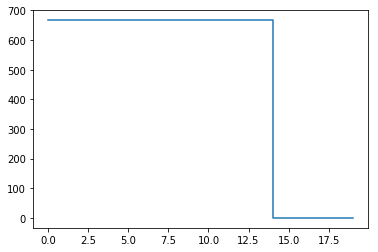

In [12]:
plt.step(range(N_steps),np.concatenate(input_1.ots.predict[-1]['v_out']))
plt.show()

In [13]:
s_list = []
win_size_list = []
t = []

n_steps = 100

for k in range(n_steps):
    s_k = nw.nodes.apply(lambda row: row['node'].s, axis=1).tolist()
    win_size = nw.connections.apply(lambda row: row['prop'].window_size, axis=1).tolist()

    s_list.append(s_k)
    win_size_list.append(win_size)
    t.append(nw.t)

    nw.simulate()

    if nw.t_next_iter <= nw.t:
        nw.run_ots()

    if np.mod(k, 10) == 0:
        print('{} % completed'.format(100*k/n_steps))

0.0 % completed
This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du al

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

50.0 % completed
This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du a

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      770
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e55aa7b70>,
      dtype=object)

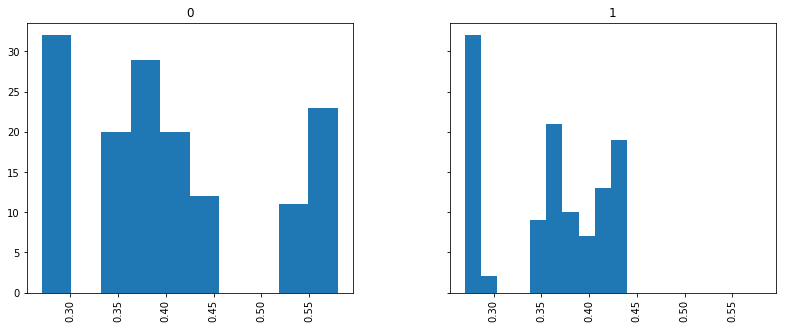

In [14]:
dat.packet_list[dat.packet_list['ttransit'] != np.inf].hist(by='circuit', column='ttransit', figsize=[13, 5], sharex=True, sharey=True)


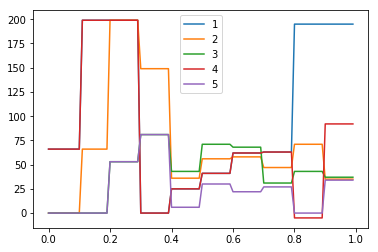

In [19]:
lines=plt.plot(t,np.array(win_size_list))
plt.legend(lines,'12345')

In [16]:
nw.nodes.loc[4]

node               <ns_f.ns_f.server object at 0x7f4e55b13fd0>
name                                                   input_2
con_target                 [False, False, False, False, False]
n_in                                                         0
con_source                  [False, False, False, True, False]
n_out                                                        1
output_circuits                                          [[1]]
input_circuits                                              []
s_circuit                                             [[1887]]
s_buffer                                                [1887]
Name: 4, dtype: object